In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import mpld3 

from sklearn.model_selection import StratifiedShuffleSplit
from preprocess import load_data_from_files

%matplotlib notebook
# mpld3.enable_notebook()

print("Done Initializing")

Done Initializing


In [2]:
num_samples = 20
to_polar = False

X, y = load_data_from_files("./Throws", num_samples=num_samples, graph=-1, to_polar=to_polar)

print("Finished Loading! data: %s, targets: %s" %(X.shape, y.shape))

hand_1.txt
hand_2.txt
hand_3.txt
hand_4.txt
hand_5.txt
throw_1.txt
throw_2.txt
throw_3.txt
throw_4.txt
throw_5.txt
throw_6.txt
throw_7.txt
Finished Loading! data: (1513, 20, 3), targets: (1513,)


In [3]:
X = X.reshape(X.shape[0], -1)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

X_train = []
y_train = []
X_test = []
y_test = []

for train_index, test_index in split.split(X, y):
    X_train = X[train_index].copy()
    y_train = y[train_index].copy()
    
    X_test = X[test_index].copy()
    y_test = y[test_index].copy()
    
num_train = y_train.shape[0]
num_test = y_test.shape[0]

num_classes = np.unique(y).shape[0]

# Format the label data as one hot
temp_y_train = y_train.copy()
temp_y_test = y_test.copy()

y_train = np.zeros((num_train, num_classes))
y_test = np.zeros((num_test, num_classes))

y_train[range(num_train), temp_y_train] = 1
y_test[range(num_test), temp_y_test] = 1

In [4]:
import tensorflow as tf
print("Done tensorflow import")

Done tensorflow import


In [23]:
# Training params
learning_rate = 5e-1
display_step = 500
batch_size = 50
maxiter = 10000

num_acc_axis = 3

# Net params
stride = 1
n_conv_layer = 5
n_conv_out = int(num_samples/stride)
n_hidden_1 = 10
n_hidden_2 = 10

# Graph input
X_layer = tf.placeholder("float", [None, num_samples*num_acc_axis], name="input_layer")
Y_layer = tf.placeholder("float", [None, num_classes], name="output_layer")

# Store weights and biases
conv_layer = tf.Variable(tf.random_normal([n_conv_layer, num_acc_axis, 1]), name="conv_filter")

weights = {
    'w1': tf.Variable(tf.random_normal([num_samples*num_acc_axis, n_hidden_1]), name="W1"),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name="W2"),
    'w3': tf.Variable(tf.random_normal([n_hidden_2, num_classes]), name="W3")
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1]), name="b1"),
    'b2': tf.Variable(tf.zeros([n_hidden_2]), name="b2"),
    'b3': tf.Variable(tf.zeros([num_classes]), name="b3")
}

Step 1, Minibatch Loss= 3536.9836, Minibatch accuracy= 0.520
Step 500, Minibatch Loss= 0.1469, Minibatch accuracy= 0.940
Step 1000, Minibatch Loss= 0.5052, Minibatch accuracy= 0.880
Step 1500, Minibatch Loss= 0.1493, Minibatch accuracy= 0.940
Step 2000, Minibatch Loss= 0.1334, Minibatch accuracy= 0.960
Step 2500, Minibatch Loss= 0.1638, Minibatch accuracy= 0.920
Step 3000, Minibatch Loss= 0.2448, Minibatch accuracy= 0.880
Step 3500, Minibatch Loss= 0.0956, Minibatch accuracy= 0.960
Step 4000, Minibatch Loss= 0.0574, Minibatch accuracy= 1.000
Step 4500, Minibatch Loss= 0.0588, Minibatch accuracy= 0.980
Step 5000, Minibatch Loss= 0.0701, Minibatch accuracy= 0.980
Step 5500, Minibatch Loss= 0.1366, Minibatch accuracy= 0.940
Step 6000, Minibatch Loss= 0.0365, Minibatch accuracy= 1.000
Step 6500, Minibatch Loss= 0.1319, Minibatch accuracy= 0.960
Step 7000, Minibatch Loss= 0.1268, Minibatch accuracy= 0.960
Step 7500, Minibatch Loss= 0.1225, Minibatch accuracy= 0.960
Step 8000, Minibatch Loss

<IPython.core.display.Javascript object>


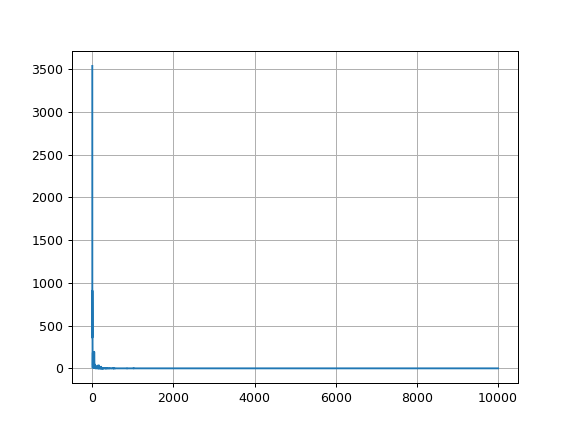

Optimaztion Finished!
Final test score 92.079000
On 1210 training samples, and 303 test samples


In [24]:
sess = tf.InteractiveSession()

# Create model computations
def neural_net(x):
    # Convolve with trainable filter to turn the data to a 2d matrix
#     conv = tf.nn.conv1d(x, conv_layer, stride, "SAME")
#     conv = tf.reshape(conv, [batch_size, n_conv_out])
    
    # Hidden fully connected layer with relu
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)

    # Hidden fully connected layer with relu
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    scores = tf.nn.relu(layer_2)

    # Output fully connected layer with a neuron for each class
    scores = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])

    return scores

# Construct model
logits = neural_net(X_layer)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits,
    labels=Y_layer))

optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y_layer, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Merge all the summerise and write them out to C:/train
train_writer = tf.summary.FileWriter("C:" + '/train', sess.graph)

init_op = tf.global_variables_initializer()

final_scores = 0
losses = []

# Optimization
with tf.Session() as sess:
    # Run initializer
    sess.run(init_op)

    for step in range(1, maxiter+1):
        # Create random choice 'batch_size' size batch
        mask_idx = np.random.choice(range(X_train.shape[0]), batch_size)
        X_batch, y_batch = X_train[mask_idx], y_train[mask_idx]

        # Run optimization op
        sess.run(train_op, feed_dict={X_layer: X_batch, Y_layer: y_batch})
        losses.append(sess.run([loss_op], feed_dict = {X_layer: X_batch, Y_layer: y_batch}))

        if ((step % display_step == 0) or (step == 1)):
            # Calculate batch loss and accuracy
            loss, acc = sess.run(
                [loss_op, accuracy],
                feed_dict = {X_layer: X_batch, Y_layer: y_batch}
            )

            print("Step " + str(step) \
                + ", Minibatch Loss= " + "{:.4f}".format(loss) \
                + ", Minibatch accuracy= " + "{:.3f}".format(acc))

    final_scores = sess.run(accuracy, feed_dict={X_layer: X_test,
                                      Y_layer: y_test})
    plt.plot(losses)
    print("Optimaztion Finished!")

print("Final test score %f" %(round(final_scores*100, 3)))
print("On %d training samples, and %d test samples" %(X_train.shape[0], X_test.shape[0]))

plt.grid()
plt.show()